In [1]:
import numpy as np
import jax.numpy as jnp
import jax
from jax import grad, vmap, jit, partial, random, jacrev
from jax.experimental.ode import odeint
from jax.experimental import optimizers
from jax.scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
key = random.PRNGKey(0)
import pickle
%matplotlib inline 
%precision 5
plt.rcParams.update({'font.size': 15})
from NODE_fns import NODE_S
from NODE_fns import NN

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Neural ODE

In [2]:
#Load the NN
model_name = 'P12AC1_xybsxsy'
with open('savednet/' + model_name + '.npy', 'rb') as f:
    params = pickle.load(f)
J_weights = np.abs(params[10])
theta = params[-1]

#### Numerically estimate the elasticity tensor, $\mathbb{C}$, for the time being

In [3]:
#Method 1: Manual numerical differentiation
def sig(F_2D):
    C_2D = jnp.dot(F_2D.T, F_2D)
    S = eval_S(C_2D)
    return jnp.einsum('ij,jk,kl->il', F_2D, S, F_2D.T)

def eval_S(C_2D):
    detC_2D = jnp.linalg.det(C_2D)
    C_3D = jnp.array([[C_2D[0,0], C_2D[0,1], 0],\
                      [C_2D[1,0], C_2D[1,1], 0],\
                      [0,         0, 1/detC_2D]])
    S = NODE_S(C_3D, params)
    return S[:2,:2]
    
def eval_dSdC(C_2D):
    dSdC = np.zeros([2,2,2,2])
    epsilon = 1.e-3
    
    for i in range(2):
        for j in range(2):
            C_p = np.array(C_2D)
            C_m = np.array(C_2D)
            C_p[i,j]+= epsilon
            C_p[j,i]+= epsilon
            C_m[i,j]-= epsilon
            C_m[j,i]-= epsilon
            
            S_p = eval_S(C_p)
            S_m = eval_S(C_m)
            dSdC[:,:,i,j] = (S_p-S_m)/(4*epsilon)
    return dSdC
#Method 2: Automatic differentiation with Jax
jdSdC = jacrev(eval_S)
#I have confirmed that the two methods above work the same.

In [4]:
#Method 3: Analytical calculation
d2Psid2I = grad(NN)
#J_weights[0] = J_weights[1] = J_weights[2] = J_weights[3] = J_weights[4] = J_weights[5] = 0

def eval_Psi_i(i, I): #First index: which partial deriv do you want? Second index: array of invariants
    I[0] = I[0]-3
    I[1] = I[1]-3
    I[2] = I[2]-1
    I[3] = I[3]-1
    J = np.zeros(6)
    J[0] = I[0] + I[1]
    J[1] = I[0] + I[2]
    J[2] = I[0] + I[3]
    J[3] = I[1] + I[2]
    J[4] = I[1] + I[3]
    J[5] = I[2] + I[3]
    index_matrix = [[0,1,2], [0,3,4], [1,3,5], [2,4,5]] #Suppose i = 3, you know that I[3] appears in J[2], J[4] and J[5], hence [2,4,5].
    
    Psi_i = NN(np.array([I[i]]), params[i])
    for j in index_matrix[i]:
        Psi_i+= J_weights[j]*NN(np.array([J[j]]), params[j+4])
    return Psi_i
    
def dyadic(A,B):
    return np.einsum('ij,kl->ijkl', A, B)

def eval_CC(C): #C in 2D as input
    v0 = np.array([ np.cos(theta), np.sin(theta), 0])
    w0 = np.array([-np.sin(theta), np.cos(theta), 0])
    V0 = np.outer(v0, v0)
    W0 = np.outer(w0, w0)
    
    detC = np.linalg.det(C)
    Cinv = np.linalg.inv(C)
    C33 = 1/detC
    I1_2D = np.trace(C)
    C_3D = np.array([[C[0,0], C[0,1], 0],\
                     [C[1,0], C[1,1], 0],\
                     [0,    0,      C33]])
    C2 = np.einsum('ij,jk->ik', C_3D, C_3D)
    I = np.eye(2)
    II = 0.5*(np.einsum('ik,jl->ijkl', I, I) + np.einsum('il,jk->ijkl', I, I))
    I1 = np.trace(C_3D)
    I2 = 0.5*(I1**2 - np.trace(C2))
    I4v = np.einsum('ij,ij',C_3D,V0)
    I4w = np.einsum('ij,ij',C_3D,W0)
    
    if I4v < 1.0:
        I4v = 1.0
    if I4w < 1.0:
        I4w = 1.0
        
    V0 = V0[:2, :2]
    W0 = W0[:2, :2]
    
    Psi1  = eval_Psi_i(0,[I1,I2,I4v,I4w])
    Psi2  = eval_Psi_i(1,[I1,I2,I4v,I4w])
    Psi4v = eval_Psi_i(2,[I1,I2,I4v,I4w])
    Psi4w = eval_Psi_i(3,[I1,I2,I4v,I4w])
    
    #Numerically calculate the 2nd derivatives
    e = 1.e-3 #=epsilon, a small number
    Psi1_p  = eval_Psi_i(0,[I1+e,I2,I4v,I4w])
    Psi1_m  = eval_Psi_i(0,[I1-e,I2,I4v,I4w])
    Psi11   = (Psi1_p - Psi1_m)/2/e
    Psi2_p  = eval_Psi_i(1,[I1,I2+e,I4v,I4w])
    Psi2_m  = eval_Psi_i(1,[I1,I2-e,I4v,I4w])
    Psi22   = (Psi2_p - Psi2_m)/2/e
    Psi4v_p = eval_Psi_i(2,[I1,I2,I4v+e,I4w])
    Psi4v_m = eval_Psi_i(2,[I1,I2,I4v-e,I4w])
    Psi4v4v = (Psi4v_p - Psi4v_m)/2/e
    Psi4w_p = eval_Psi_i(3,[I1,I2,I4v,I4w+e])
    Psi4w_m = eval_Psi_i(3,[I1,I2,I4v,I4w-e])
    Psi4w4w = (Psi4w_p - Psi4w_m)/2/e
    #Mixed partials
    Psi1_p  = eval_Psi_i(0,[I1,I2+e,I4v,I4w])
    Psi1_m  = eval_Psi_i(0,[I1,I2-e,I4v,I4w])
    Psi12   = (Psi1_p - Psi1_m)/2/e
    Psi1_p  = eval_Psi_i(0,[I1,I2,I4v+e,I4w])
    Psi1_m  = eval_Psi_i(0,[I1,I2,I4v-e,I4w])
    Psi14v  = (Psi1_p - Psi1_m)/2/e
    Psi1_p  = eval_Psi_i(0,[I1,I2,I4v,I4w+e])
    Psi1_m  = eval_Psi_i(0,[I1,I2,I4v,I4w-e])
    Psi14w  = (Psi1_p - Psi1_m)/2/e
    Psi2_p  = eval_Psi_i(1,[I1,I2,I4v+e,I4w])
    Psi2_m  = eval_Psi_i(1,[I1,I2,I4v-e,I4w])
    Psi24v  = (Psi2_p - Psi2_m)/2/e
    Psi2_p  = eval_Psi_i(1,[I1,I2,I4v,I4w+e])
    Psi2_m  = eval_Psi_i(1,[I1,I2,I4v,I4w-e])
    Psi24w  = (Psi2_p - Psi2_m)/2/e
    Psi4v_p = eval_Psi_i(2,[I1,I2,I4v,I4w+e])
    Psi4v_m = eval_Psi_i(2,[I1,I2,I4v,I4w-e])
    Psi4v4w = (Psi4v_p - Psi4v_m)/2/e
    
    #Psi2 = Psi22 = Psi12 = Psi24v = Psi24w = 0
    
    d1  = 4*(Psi11 + 2*Psi12*(I1_2D + C33) + Psi22*(I1_2D**2 + 2*I1_2D*C33 + C33**2) + Psi2)
    d2  = 4*(-Psi11*C33 - 2*Psi12*I1_2D*C33 - Psi12*C33**2 - Psi22*I1_2D*C33*(I1_2D+C33) - Psi2*C33)
    d3  = 4*(-Psi12 - Psi22*I1_2D - Psi22*C33)
    d4  = 4*(Psi12*C33 + Psi22*I1_2D*C33)
    d5  = 4*Psi22
    d6  = -4*Psi2
    d7  = 4*Psi4v4v
    d8  = 4*Psi4w4w
    d9  = 4*(Psi11*C33**2 + 2*Psi12*I1_2D*C33**2 + Psi1*C33 + Psi22*C33**2*I1_2D**2 + Psi2*I1_2D*C33)
    d10 = 4*(Psi1*C33 + Psi2*I1_2D*C33)
    d11 = 4*(Psi14v + Psi24v*(I1_2D + C33))
    d12 = 4*(Psi14w + Psi24w*(I1_2D + C33))
    d13 = 4*(-Psi14v*C33 - Psi24v*I1_2D*C33)
    d14 = 4*(-Psi14w*C33 - Psi24w*I1*C33)
    d15 = -4*Psi24v
    d16 = -4*Psi24w
    
    CC = d1*  dyadic(I,I)                                                                     + \
         d2* (dyadic(I,Cinv) + dyadic(Cinv,I))                                                + \
         d3* (dyadic(I,C) + dyadic(C,I))                                                      + \
         d4* (dyadic(C,Cinv) + dyadic(Cinv,C))                                                + \
         d5*  dyadic(C,C)                                                                     + \
         d6*  II                                                                              + \
         d7*  dyadic(V0,V0)                                                                   + \
         d8*  dyadic(W0,W0)                                                                   + \
         d9*  dyadic(Cinv, Cinv)                                                              + \
         d10*0.5*(np.einsum('ik,lj->ijkl',Cinv, Cinv) + np.einsum('il,kj->ijkl', Cinv, Cinv)) + \
         d11*(dyadic(I,V0) + dyadic(V0,I))                                                    + \
         d12*(dyadic(I,W0) + dyadic(W0,I))                                                    + \
         d13*(dyadic(Cinv,V0) + dyadic(V0,Cinv))                                              + \
         d14*(dyadic(Cinv,W0) + dyadic(W0,Cinv))                                              + \
         d15*(dyadic(C,V0) + dyadic(V0,C))                                                    + \
         d16*(dyadic(C,W0) + dyadic(W0,C))
    return CC

# Finite Element Method

In [6]:
#Generate nodes and elements
n_node = 25
n_elem = int((np.sqrt(n_node)-1))**2
node_X, node_Y = np.meshgrid(np.linspace(0,1,5),np.linspace(0,1,5))
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

elements = np.zeros((n_elem, 4), dtype=np.int8)

i=0
j=0
while i < n_node - 5:
    if i == 0 or (i+1)%5 != 0:
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+6
        elements[j,1] = i+5
        j+= 1
    i+= 1

Text(0.5, 1.0, 'Undeformed Mesh')

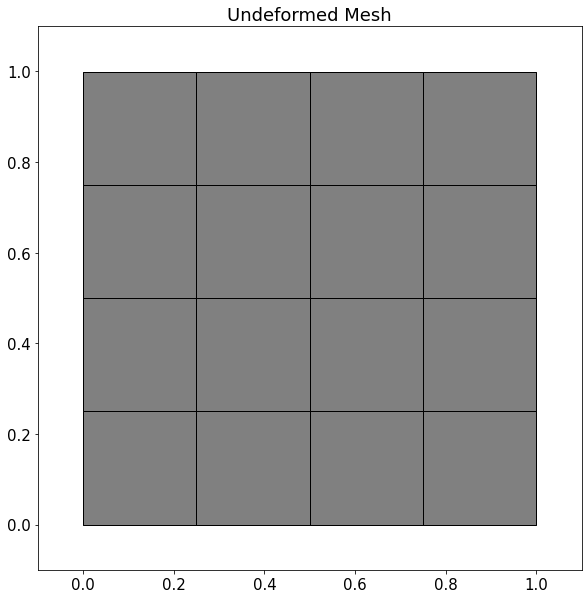

In [7]:
# plot mesh to check
## Plot the mesh 
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], edgecolor='r', facecolor=None, closed=True)
    patches.append(polygon)
    colors[i] = np.random.rand()
p = PatchCollection(patches, edgecolor='k', facecolor='gray')
#p.set_array(colors)
ax.add_collection(p)
ax.set_title("Undeformed Mesh")
# fig.savefig('Figures/FEM/undeformed.jpg', dpi=400, bbox_inches='tight')

In [8]:
# Shape functions and derivatives 

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

In [9]:
## Vahid: create DOF map (In this case shearing)
node_x = np.zeros_like(node_X)#np.zeros(node_X.shape)
DOF_fmap = np.zeros((n_node,2),dtype=int)
DOF_imap = [] 
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 0
        if X[1] < 0.001:
            DOF_fmap[i,1] = -1
            node_x[i,1] = 0
        else:
            DOF_fmap[i,1] = dof
            DOF_imap.append([i,0])
            dof+= 1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.1
        DOF_fmap[i,1] = -1
        node_x[i,1] = node_x[i,1] + 0.1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 
        DOF_imap.append([i,0])
        DOF_imap.append([i,1])

Text(0.5, 1.0, 'Deformed Mesh (Before Analysis)')

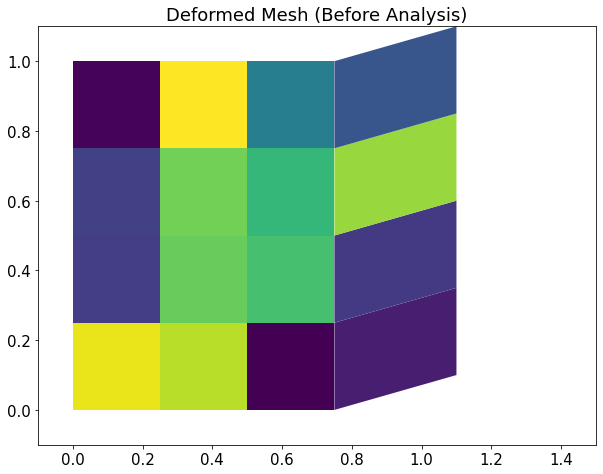

In [10]:
## Plot the deformed mesh 
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.5])
ax.set_ylim([-0.1, 1.1])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches.append(polygon)
    colors[i] = np.random.rand()
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)
ax.set_title("Deformed Mesh (Before Analysis)")

## Compute the element residual and tangent and assemble into global residual and tangent



In [11]:
# putting it inside a function
def assembleRRKK():
    # assemble total residual 
    RR = np.zeros(n_node*2)
    # assemble the total tangent 
    KK = np.zeros((n_node*2,n_node*2))
    # loop over elements
    for ei in range(n_elem):
        # initialize the residual for this element
        Re = np.zeros((8))
        # initialize the tangent for this element
        Ke = np.zeros((8,8))

        # nodes that make up this element 
        node_ei = elements[ei]
        # reference coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_X_ei = np.zeros((4,2))
        # deformed coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_x_ei = np.zeros((4,2))
        for ni in range(4):
            node_X_ei[ni] = node_X[node_ei[ni]]
            node_x_ei[ni] = node_x[node_ei[ni]]
            
        #print(node_x_ei)
        # also, do a proper integration with four integration points 
        # Loop over integration points
        # location and weight of integration points 
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                          [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wi = IP_wi[ip]
            # eval shape functions 
            Ns = Nvec(xi,eta)
            # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
            X = np.zeros((2))
            x = np.zeros((2))
            for ni in range(4):
                X += Ns[ni]*node_X_ei[ni]
                x += Ns[ni]*node_x_ei[ni]

            # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
            dNsdxi = dNvecdxi(xi,eta)
            dXdxi = np.zeros((2,2))
            dxdxi = np.zeros((2,2))
            for ni in range(4):
                dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])
                dxdxi += np.outer(node_x_ei[ni],dNsdxi[:,ni])
            # get gradient of basis function with respect to X using inverse jacobian 
            JinvT = np.linalg.inv(dXdxi).transpose()
            dNsdX = np.dot(JinvT,dNsdxi)

            # get gradient of basis function with respect to x using inverse jacobian, the other one 
            jinvT = np.linalg.inv(dxdxi).transpose()
            dNsdx = np.dot(jinvT,dNsdxi)

            # get the deformation gradient 
            F = np.zeros((2,2))
            for ni in range(4):
                F += np.outer(node_x_ei[ni],dNsdX[:,ni])
            # compute the stress
            detF = np.linalg.det(F)
            b = np.dot(F,F.transpose())
            C = np.dot(F.transpose(),F)
            c1 = 1.0 
            p = 2*c1/(detF*detF)
            
            ################ Stress ####################
            #sigma = -p*np.eye(2) + 2*c1*b #Original

            sigma = sig(F)
            
            # compute the variation of the symmetric velocity gradient by moving one node and one component
            # of that node at a time, except if the node is on the boundary in which case no variation is allowed
            for ni in range(4):
                for ci in range(2):
                    deltav = np.zeros((2))
                    # note, no worries about the boundary because we will get rid of the corresponding rows
                    # of the residual because they wont be zero 
                    deltav[ci] = 1
                    gradx_v = np.outer(deltav,dNsdx[:,ni])
                    deltad = 0.5*(gradx_v + gradx_v.transpose())
                    Re[ni*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)

                    RR[node_ei[ni]*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)
                    
                    ## 2 more for loops for the increment Delta u
                    for nj in range(4):
                        for cj in range(2):
                            Deltau = np.zeros((2))
                            Deltau[cj]=1
                            gradx_Du = np.outer(Deltau,dNsdx[:,nj])
                            Deltaeps = 0.5*(gradx_Du + gradx_Du.transpose())
                            
                            ## ELEMENT TANGENT
                            # Initial stress component (also called geometric component) is 
                            # sigma: (gradDeltau^T gradv)
                            Kgeom = np.tensordot(sigma,np.dot(gradx_Du.transpose(),gradx_v))
                            # Material component, need to put things in voigt notation for easy computation
                            deltad_voigt = np.array([deltad[0,0],deltad[1,1],2*deltad[0,1]])
                            Deltaeps_voigt = np.array([Deltaeps[0,0],Deltaeps[1,1],2*Deltaeps[0,1]])
                            
                            
                            ################ Elastic Moduli ####################
#                             CC = 2*eval_dSdC(C)
                            CC = eval_CC(C)
#                             CC = 2*jdSdC(C) #Don't use this, doesn't work.
#                             CC = (CC + np.transpose(CC, axes=[0,1,3,2]))/2 #jdSdC does not have minor symmetry, so impose it manually.
                            cc = np.einsum('ij,kl,mn,op,jlnp->ikmo', F, F, F, F, CC)
                            #D == cc_voigt
                            D = np.zeros((3,3))
                            Itoi = [0,1,0]
                            Itoj = [0,1,1]
                            for I in range(3):
                                for J in range(3):
                                    i = Itoi[I]
                                    j = Itoj[I]
                                    k = Itoi[J]
                                    l = Itoj[J]
                                    D[I,J] = cc[i,j,k,l] #D: cc in voigt notation
                            
                            #D = np.array([[4*p,2*p,0],[2*p,4*p,0],[0,0,2*p]])
                            Kmat = np.dot(Deltaeps_voigt,np.dot(D,deltad_voigt))
                            # add to the corresponding entry in Ke and dont forget other parts of integral
                            Ke[ni*2+ci,nj*2+cj] += wi*np.linalg.det(dxdxi)*(Kgeom+Kmat)
                            # assemble into global 
                            KK[node_ei[ni]*2+ci,node_ei[nj]*2+cj] += wi*np.linalg.det(dxdxi)*(Kgeom+Kmat)
#         print(F)
#         print(D)
#         print(sigma)
#         print('--------')
                            
    return RR,KK

In [12]:
 def plot_stress(mode = 'uni'):
    plt.rcParams.update({'font.sans-serif':'Arial'})
    ## Plot the deformed mesh, evaluate the stress at the center
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    ax[0].set_xlim([-0.1, 1.3])
    ax[0].set_ylim([-0.1, 1.3])
    ax[0].set_aspect('equal')
    
    ax[1].set_xlim([-0.1, 1.3])
    ax[1].set_ylim([-0.1, 1.3])
    ax[1].set_aspect('equal')
    patches = []
    #viridis = matplotlib.cm.get_cmap('viridis', 50)
    colors1 = np.zeros((n_elem))
    colors2 = np.zeros((n_elem))
    
    for i in range(n_elem):
        n1 = elements[i,0]
        n2 = elements[i,1]
        n3 = elements[i,2]
        n4 = elements[i,3]
        polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
        patches.append(polygon)
        # compute stress at center 
        xi  = 0
        eta = 0
        # eval shape functions 
        Ns = Nvec(xi,eta)
        # eval the isoparametric map 
        X = Ns[0]*node_X[n1]+Ns[1]*node_X[n2]+Ns[2]*node_X[n3]+Ns[3]*node_X[n4]
        X = Ns[0]*node_x[n1]+Ns[1]*node_x[n2]+Ns[2]*node_x[n3]+Ns[3]*node_x[n4]
        # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
        dNsdxi = dNvecdxi(xi,eta)
        dXdxi = np.outer(node_X[n1],dNsdxi[:,0])+np.outer(node_X[n2],dNsdxi[:,1])\
                +np.outer(node_X[n3],dNsdxi[:,2])+np.outer(node_X[n4],dNsdxi[:,3])
        dxdxi = np.outer(node_x[n1],dNsdxi[:,0])+np.outer(node_x[n2],dNsdxi[:,1])\
                +np.outer(node_x[n3],dNsdxi[:,2])+np.outer(node_x[n4],dNsdxi[:,3])
        # get gradient of basis function with respect to X using inverse jacobian 
        JinvT = np.linalg.inv(dXdxi).transpose()
        dNsdX = np.dot(JinvT,dNsdxi)
        # get gradient of basis function with respect to x using inverse jacobian, the other one 
        jinvT = np.linalg.inv(dxdxi).transpose()
        dNsdx = np.dot(jinvT,dNsdxi)
        # get the deformation gradient 
        F = np.outer(node_x[n1],dNsdX[:,0])+np.outer(node_x[n2],dNsdX[:,1])\
            +np.outer(node_x[n3],dNsdX[:,2])+np.outer(node_x[n4],dNsdX[:,3])
        detF = np.linalg.det(F)
        b = np.dot(F,F.transpose())
        c1 = 1.0 
        p = 2*c1/(detF*detF)

        #################### Stress ####################
        #sigma = -p*np.eye(2) + 2*c1*b
        sigma = sig(F)
        #print(node_x[n1], node_x[n2], node_x[n3], node_x[n4])
        #print(F)
        #print(sigma[1,1]*1000)
        colors1[i] = sigma[0,0]*1000
        colors2[i] = sigma[1,1]*1000
        #colors[i] = np.random.rand()
    p1 = PatchCollection(patches, edgecolor='k')
    p2 = PatchCollection(patches, edgecolor='k')
    p1.set_array(colors1)
    p2.set_array(colors2)
    p1.set_cmap('Blues')
    p2.set_cmap('Blues')
    if mode=='uni':
        #Uniaxial:
        p1.set_clim([15,21])
        p2.set_clim([-0.5,0.5])
    elif mode=='she':
        #Shear:
        p1.set_clim(vmin=8)
        p2.set_clim(vmin=-0.3)
    elif mode=='tor':
        #Torsion:
        p1.set_clim(vmin=9.8)
        p2.set_clim(vmin=-0.1)
        
    ax[0].add_collection(p1)
    ax[1].add_collection(p2)
    ax[0].set(xlabel = '$\sigma_{xx}$ [kPa]', xlim=[-0.1,1.2])
    ax[1].set(xlabel = '$\sigma_{yy}$ [kPa]', xlim=[-0.1,1.2])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    if mode=='uni':
        #Uniaxial:
        plt.colorbar(p1,ax=ax[0], label='$\sigma_{xx}$ [kPa]', fraction = 0.03, boundaries=[15,16,17,18,19,20,21])
        plt.colorbar(p2,ax=ax[1], label='$\sigma_{yy}$ [kPa]', fraction = 0.03, boundaries=[-0.5,-0.25,0.25,0.5])
        #fig.savefig('Figures/FEM/uni.jpg', dpi=400, bbox_inches='tight')
    elif mode=='she':
        #Shear:
        plt.colorbar(p1,ax=ax[0], label='$\sigma_{xx}$ [kPa]', fraction = 0.03, boundaries=[9,10,11,12,13])
        plt.colorbar(p2,ax=ax[1], label='$\sigma_{yy}$ [kPa]', fraction = 0.03, boundaries=[0,0.4,0.8,1.0,1.2])
        #fig.savefig('Figures/FEM/she.jpg', dpi=400, bbox_inches='tight')
    elif mode=='tor':
        #Torsion:
        plt.colorbar(p1,ax=ax[0], label='$\sigma_{xx}$ [kPa]', fraction = 0.03, boundaries=[9.8,9.85,9.9,9.95,10])
        plt.colorbar(p2,ax=ax[1], label='$\sigma_{yy}$ [kPa]', fraction = 0.03, boundaries=[0,0.2,0.4,0.6,0.8])
        #fig.savefig('Figures/FEM/tor.jpg', dpi=400, bbox_inches='tight')

# Uniaxial Tension

iter 5
0.0069026289524600016
iter 10
5.69131521604473e-05


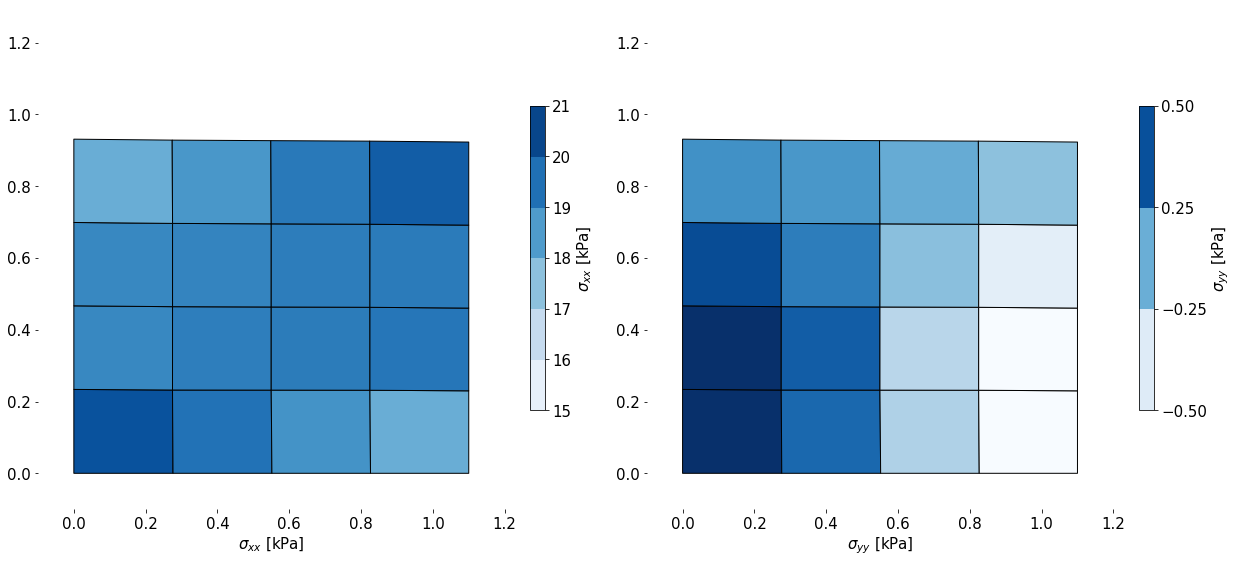

In [13]:
node_x = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
DOF_imap = [] 
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 0
        if X[1] < 0.001:
            DOF_fmap[i,1] = -1
            node_x[i,1] = 0
        else:
            DOF_fmap[i,1] = dof
            DOF_imap.append([i,0])
            dof+= 1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.1
        if X[1]<0.001:
            DOF_fmap[i,1] = -1
            node_x[i,1] = 0
        else:
            DOF_fmap[i,1] = dof
            DOF_imap.append([i,1])
            dof+= 1
    elif X[1]<0.001:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = -1
        node_x[i,1] = 0
        dof+=1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 
        DOF_imap.append([i,0])
        DOF_imap.append([i,1])
        
## Newton Raphson 
res = 5
iter = 0
tol = 1e-5
itermax = 10
while res>tol and iter<itermax:
    RR,KK = assembleRRKK()
    # for the increment not all of the KK is needed because some nodes have essential BC
    RRdof = RR[DOF_fmap.flatten()>=0]
    KKdof = KK[DOF_fmap.flatten()>=0]
    KKdof = KKdof[:,DOF_fmap.flatten()>=0]
    res = np.linalg.norm(RRdof)
    incr_u = -np.linalg.solve(KKdof,RRdof)
    j = 0
    for i in range(n_node):
        if DOF_fmap[i,0] >= 0:
            node_x[i,0]+= incr_u[j]
            j+= 1
        if DOF_fmap[i,1] >= 0:
            node_x[i,1]+= incr_u[j] 
            j+= 1
    iter +=1
    if iter%5 == 0:
        print('iter %i'%iter)
        print(res)
plot_stress('uni')
with open('FEM_data/uni_coarse.dat' , 'wb') as f:
    pickle.dump(node_x, f)

# Shearing

iter 5
0.12199056224323586
iter 10
0.00011293908650002044


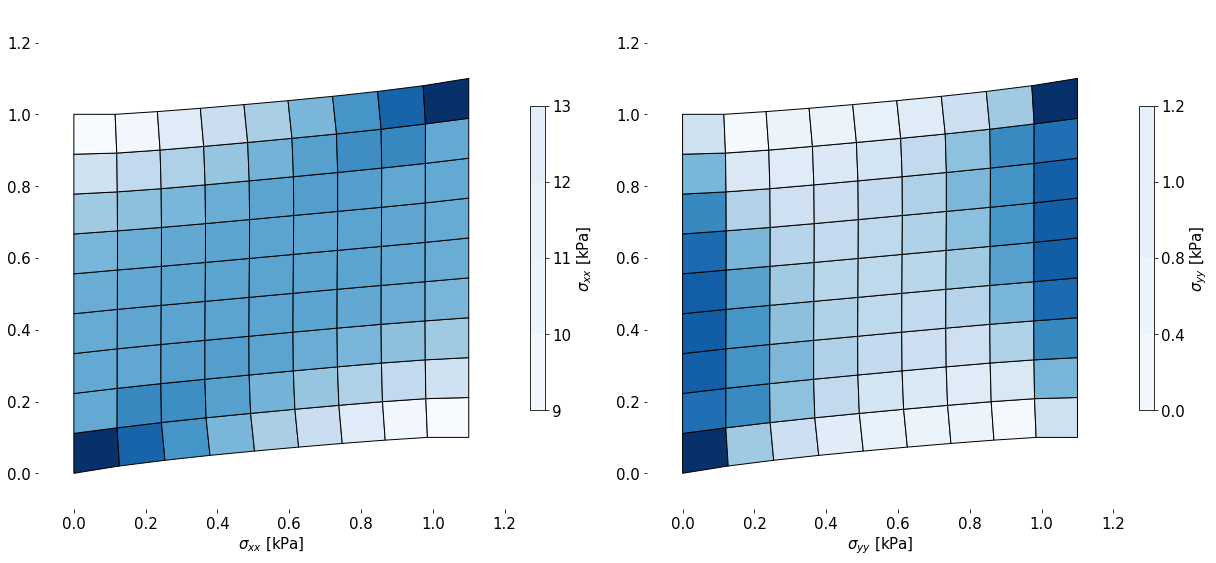

In [23]:
node_x = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
DOF_imap = [] 
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 0
        DOF_fmap[i,1] = -1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.1
        DOF_fmap[i,1] = -1
        node_x[i,1] = node_x[i,1] + 0.1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 
        DOF_imap.append([i,0])
        DOF_imap.append([i,1])
        
## Newton Raphson 
res = 5
iter = 0
tol = 1e-5
itermax = 10
while res>tol and iter<itermax:
    RR,KK = assembleRRKK()
    # for the increment not all of the KK is needed because some nodes have essential BC
    RRdof = RR[DOF_fmap.flatten()>=0]
    KKdof = KK[DOF_fmap.flatten()>=0]
    KKdof = KKdof[:,DOF_fmap.flatten()>=0]
    res = np.linalg.norm(RRdof)
    incr_u = -np.linalg.solve(KKdof,RRdof)
    j = 0
    for i in range(n_node):
        if DOF_fmap[i,0] >= 0:
            node_x[i,0]+= incr_u[j]
            j+= 1
        if DOF_fmap[i,1] >= 0:
            node_x[i,1]+= incr_u[j]
            j+= 1
    iter +=1
    if iter%5 == 0:
        print('iter %i'%iter)
        print(res)
plot_stress('she')
with open('FEM_data/she_coarse.dat' , 'wb') as f:
    pickle.dump(node_x, f)

# Clamped Uniaxial Tension

iter 5
0.07539973619218027
iter 10
1.913454385145989e-05


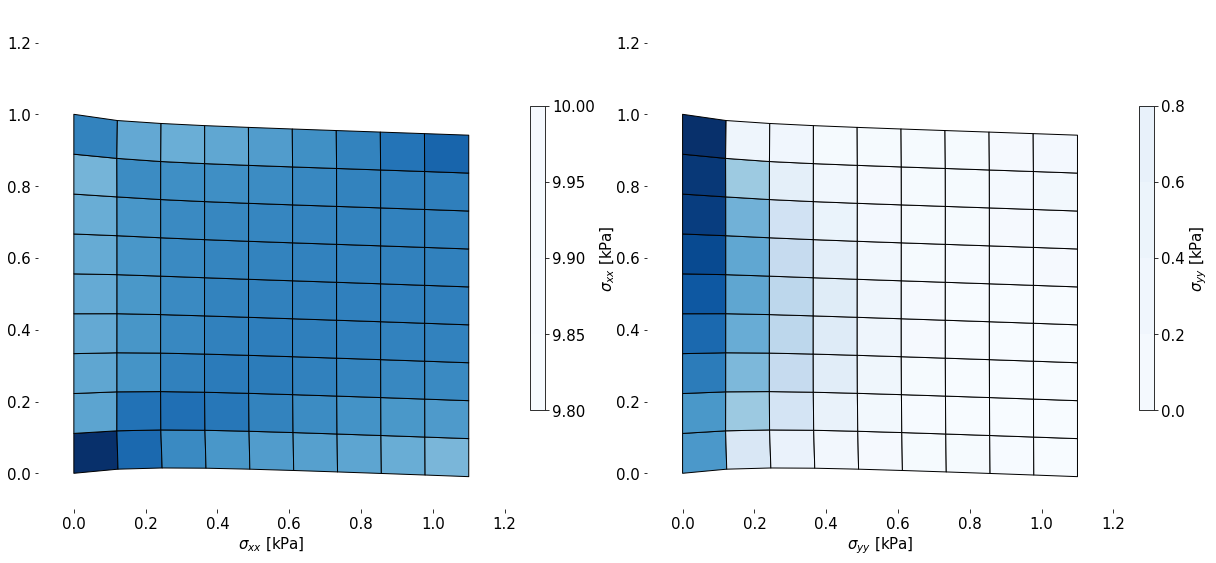

In [24]:
node_x = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
DOF_imap = [] 
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        DOF_fmap[i,1] = -1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.1
        DOF_fmap[i,1] = dof
        DOF_imap.append([i,1])
        dof+= 1
        #DOF_fmap[i,1] = -1
        #node_x[i,1] = node_x[i,1] + 0.1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 
        DOF_imap.append([i,0])
        DOF_imap.append([i,1])
        
## Newton Raphson 
res = 5
iter = 0
tol = 1e-5
itermax = 10
while res>tol and iter<itermax:
    RR,KK = assembleRRKK()
    # for the increment not all of the KK is needed because some nodes have essential BC
    RRdof = RR[DOF_fmap.flatten()>=0]
    KKdof = KK[DOF_fmap.flatten()>=0]
    KKdof = KKdof[:,DOF_fmap.flatten()>=0]
    res = np.linalg.norm(RRdof)
    incr_u = -np.linalg.solve(KKdof,RRdof)
    j = 0
    for i in range(n_node):
        if DOF_fmap[i,0] >= 0:
            node_x[i,0]+= incr_u[j]
            j+= 1
        if DOF_fmap[i,1] >= 0:
            node_x[i,1]+= incr_u[j]
            j+= 1
    iter +=1
    if iter%5 == 0:
        print('iter %i'%iter)
        print(res)
plot_stress('tor')
with open('FEM_data/tor_coarse.dat' , 'wb') as f:
    pickle.dump(node_x, f)